In [1]:
# changing core directory
import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [21]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.manifold import TSNE

# from src.attacks import fgsm_attack, only_disc_attack
# from src.attacks.utils import calculate_metrics_class_and_hiddens, req_grad
from src.config import get_disc_list
from src.data import MyDataset, load_data, transform_data
from src.models.LSTM import LSTM
# from src.utils import load_disc_model

In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf
initialize(config_path='../config', version_base=None)
cfg = compose(config_name='attack_run_config.yaml')
print(OmegaConf.to_yaml(cfg))

dataset:
  name: PowerCons
  num_classes: 2
  seq_len: 144
  total_object_count: 360
  train:
    object_count: 180
    max: 6.150072421276428
    mean: -1.7736155479814228e-16
    min: -0.9882441283924925
    std: 0.9999999999999999
    median: -0.4639090210070178
    roughness: 0.15408237025050991
  test:
    object_count: 180
    max: 6.002890636747172
    mean: -0.010892417367795152
    min: -1.0250395745248067
    std: 0.9910649059168454
    median: -0.4823067440731748
    roughness: 0.1544105925399531
attack_model:
  name: ResidualCNN
  params:
    c_in: 1
    c_out: 1
    coord: false
    separable: false
    zero_norm: false
  hyperparameters_vary:
    c_in:
      optuna_type: const
      value: 1
    c_out:
      optuna_type: const
      value: 1
  attack_train_mode: false
disc_model_reg:
  name: ResidualCNN
  params:
    c_in: 1
    c_out: 1
    coord: false
    separable: false
    zero_norm: false
  hyperparameters_vary:
    c_in:
      optuna_type: const
      value: 1
   

# NEW CODE

In [4]:
import os
import warnings

import hydra
import pandas as pd
import torch
from omegaconf import DictConfig
from torch.utils.data import DataLoader

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator
from src.utils import fix_seed
from src.attacks.regularizers import reg_disc

In [5]:
fix_seed(cfg['model_id_attack'])
print("Dataset", cfg["dataset"]["name"])
X_train, y_train, X_test, y_test = load_data(cfg["dataset"]["name"])
X_train, X_test, y_train, y_test = transform_data(
    X_train, X_test, y_train, y_test, slice_data=cfg["slice"]
)

test_loader = DataLoader(
    MyDataset(X_test, y_test), batch_size=cfg["batch_size"], shuffle=False
)

device = torch.device(cfg["device"] if torch.cuda.is_available() else "cpu")

attack_model_path = os.path.join(
        cfg["model_folder"],
        f"model_{cfg['attack_model']['name']}_{cfg['model_id_attack']}_{cfg['dataset']['name']}.pt")

attack_model = get_model(
    cfg["attack_model"]["name"],
    cfg["attack_model"]["params"],
    path=attack_model_path,
    device=device,
    train_mode=cfg["attack_model"]["attack_train_mode"],
)

Dataset PowerCons


In [6]:
path = cfg["disc_path"]

if cfg["use_disc_check"]:
    disc_check_list = get_disc_list(
        model_name=cfg["disc_model_check"]["name"],
        model_params=cfg["disc_model_check"]["params"],
        list_disc_params=cfg["list_check_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=False,
        from_clearml=False
    )
else:
    disc_check_list = None

results/PowerCons/ResidualCNN/discriminator/fgsm_attack_test/model_ResidualCNN_100_PowerCons_attack_fgsm_attack__eps=0.03__n_steps=10/model_ResidualCNN_100_PowerCons_attack_fgsm_attack__eps=0.03__n_steps=10.pt


In [7]:
criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])

disc_model_reg = get_disc_list(
    model_name=cfg["disc_model_reg"]["name"],
    model_params=cfg["disc_model_reg"]["params"],
    list_disc_params=cfg["attack"]["list_reg_model_params"],
    device=device,
    path=path,
    train_mode=cfg["disc_model_reg"]["attack_train_mode"],
    from_clearml=False
)

results/PowerCons/ResidualCNN/discriminator/fgsm_attack_test/model_ResidualCNN_100_PowerCons_attack_fgsm_attack__eps=0.03__n_steps=10/model_ResidualCNN_100_PowerCons_attack_fgsm_attack__eps=0.03__n_steps=10.pt


In [85]:
a = torch.ones(2, 3)
inner_ = torch.ones(2).unsqueeze(-1)

inner_ * a

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [90]:
def project_cone(g: torch.Tensor, a: torch.Tensor, delta=0, e=1e-7) -> torch.Tensor:
    g = g.squeeze(-1)
    a = a.squeeze(-1)

    g_grad_norm = torch.norm(g, p=1)
    num_cos_phi = (g * a).sum(dim=1)
    dem_cos_phi = torch.norm(g, dim=1) * torch.norm(a, dim=1)
    cos_phi = num_cos_phi / dem_cos_phi
    phi = torch.arccos(torch.clip(cos_phi, -1, 1))

    final_prog = torch.cos(delta) / cos_phi * torch.cos(phi + delta)
    inner_prog = torch.norm(g, dim=1) / torch.norm(a, dim=1) * (torch.sin(phi)*torch.tan(delta) - cos_phi)
    g_p = final_prog.unsqueeze(-1) * (g + a * inner_prog.unsqueeze(-1))
    g_p_grad_norm = torch.norm(g_p, p=1)
    g_p = g_p * (g_grad_norm + e) / (g_p_grad_norm + e)
    return g_p.unsqueeze(-1)

def get_loss(model, criterion, X: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    model.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y_true)
    return loss

def fgsm_step_grads(attack_model, criterion, X, y_true, attack_params):
    attack_loss = get_loss(attack_model, criterion, X, y_true)
    attack_loss_grad = torch.autograd.grad(attack_loss, X, retain_graph=True)[0]

    grad = attack_loss_grad
    grad_sign = torch.where(torch.isnan(grad), 0, torch.sign(grad))
    step = attack_params['eps'] * grad_sign
    X_adv = X.data + step
    reg_loss_grad = torch.zeros(grad.shape)
    return X_adv, attack_loss_grad, reg_loss_grad, grad, step

def disc_fgsm_step_grads(attack_model, criterion, X, y_true, attack_params):
    attack_loss = get_loss(attack_model, criterion, X, y_true)
    attack_loss_grad = torch.autograd.grad(attack_loss, X, retain_graph=True)[0]

    reg_loss = reg_disc(X, attack_params['disc_models'], attack_params['use_sigmoid'])
    reg_loss_grad = torch.autograd.grad(reg_loss, X, retain_graph=True)[0]
    grad = attack_loss - attack_params['alpha'] * reg_loss_grad

    grad_sign = torch.where(torch.isnan(grad), 0, torch.sign(grad))
    step = attack_params['eps'] * grad_sign
    X_adv = X.data + step
    return X_adv, attack_loss_grad, reg_loss_grad, grad, step

def hypercone_fgsm_step_grads(attack_model, criterion, X, y_true, attack_params):
    attack_loss = get_loss(attack_model, criterion, X, y_true)
    attack_loss_grad = torch.autograd.grad(attack_loss, X, retain_graph=True)[0]

    reg_loss = -reg_disc(X, attack_params['disc_models'], attack_params['use_sigmoid'])
    reg_loss_grad = torch.autograd.grad(reg_loss, X, retain_graph=True)[0]

    grad = project_cone(attack_loss_grad, reg_loss_grad, attack_params['delta'])

    grad_sign = torch.where(torch.isnan(grad), 0, torch.sign(grad))
    step = attack_params['eps'] * grad_sign
    X_adv = X.data + step
    return X_adv, attack_loss_grad, reg_loss_grad, grad, step

In [91]:
def prepare_data_to_attack(X: torch.Tensor, y: torch.Tensor):
    X.grad = None
    X.requires_grad = True

    X = X.to(device, non_blocking=True)
    y = y.to(device)
    return X, y

def rebuild_loader(loader, X_adv: torch.Tensor, y_true: torch.Tensor) -> DataLoader:
    dataset_class = loader.dataset.__class__
    batch_size = loader.batch_size
    dataset = dataset_class(X_adv, y_true)
    loader = DataLoader(dataset, batch_size=batch_size)
    return loader

In [92]:
def apply_attack(attack_model, criterion, loader, attack_params):
    X_data_steps = torch.FloatTensor([])
    attack_loss_grad_steps = torch.FloatTensor([])
    reg_loss_grad_steps = torch.FloatTensor([])
    final_grad_steps = torch.FloatTensor([])
    eps_step_steps = torch.FloatTensor([])

    for step_id in range(attack_params['n_steps'] + 1):

        X_adv_all_objects = torch.FloatTensor([])
        y_true_all_objects = torch.tensor([])
        attack_loss_grad_all_objects = torch.FloatTensor([])
        reg_loss_grad_objects = torch.FloatTensor([])
        final_grad_all_objects = torch.FloatTensor([])
        eps_step_all_objects = torch.FloatTensor([])

        for X, y_true in loader:
            if step_id != 0:
                X, y_true = prepare_data_to_attack(X, y_true)
                X_adv, attack_loss_grad, reg_loss_grad, final_grad, eps_step = attack_params['attack_step'](attack_model, criterion, X, y_true, attack_params)
                #print(X_adv.shape, attack_loss_grad.shape, reg_loss_grad.shape, final_grad.shape)
            else:
                X_adv, attack_loss_grad, reg_loss_grad, final_grad, eps_step = X, torch.zeros(X.shape), torch.zeros(X.shape), torch.zeros(X.shape), torch.zeros(X.shape)
            
            X_adv_all_objects = torch.cat((X_adv_all_objects, X_adv.cpu().detach()), dim=0)
            y_true_all_objects = torch.cat((y_true_all_objects, y_true.cpu().detach()), dim=0)
            attack_loss_grad_all_objects = torch.cat((attack_loss_grad_all_objects, attack_loss_grad.cpu().detach()), dim=0)
            reg_loss_grad_objects = torch.cat((reg_loss_grad_objects, reg_loss_grad.cpu().detach()), dim=0)
            final_grad_all_objects = torch.cat((final_grad_all_objects, final_grad.cpu().detach()), dim=0)
            eps_step_all_objects = torch.cat((eps_step_all_objects, eps_step.cpu().detach()), dim=0)

        loader = rebuild_loader(loader, X_adv_all_objects, y_true_all_objects)
        X_data_steps = torch.cat((X_data_steps, X_adv_all_objects))
        attack_loss_grad_steps = torch.cat((attack_loss_grad_steps, attack_loss_grad_all_objects))
        reg_loss_grad_steps = torch.cat((reg_loss_grad_steps, reg_loss_grad_objects))
        final_grad_steps = torch.cat((final_grad_steps, final_grad_all_objects))
        eps_step_steps = torch.cat((eps_step_steps, eps_step_all_objects))

    data_obj_shape = X_adv_all_objects.shape
    shape_data = (attack_params['n_steps'] + 1, data_obj_shape[0], data_obj_shape[1], data_obj_shape[2])
    X_data_steps = X_data_steps.reshape(shape_data)
    attack_loss_grad_steps = attack_loss_grad_steps.reshape(shape_data)
    reg_loss_grad_steps = reg_loss_grad_steps.reshape(shape_data)
    final_grad_steps = final_grad_steps.reshape(shape_data)
    eps_step_steps = eps_step_steps.reshape(shape_data)

    return X_data_steps, attack_loss_grad_steps, reg_loss_grad_steps, final_grad_steps, eps_step_steps

def transform_data(data, obj_id):
    X_data_steps, attack_loss_grad_steps, reg_loss_grad_steps, final_grad_steps, eps_step_steps = data
    X_obj = X_data_steps[:, :, obj_id, :]
    attack_grad_obj = attack_loss_grad_steps[:, :, obj_id, :]
    reg_grad_obj = reg_loss_grad_steps[:, :, obj_id, :]
    final_grad_obj = final_grad_steps[:, :, obj_id, :]
    eps_step_obj = eps_step_steps[:, :, obj_id, :]

    X_obj = X_obj.squeeze(-1)
    attack_grad_obj = X_obj + attack_grad_obj.squeeze(-1)
    reg_grad_obj = X_obj + reg_grad_obj.squeeze(-1)
    final_grad_obj = X_obj + final_grad_obj.squeeze(-1)
    eps_step_obj = X_obj + eps_step_obj.squeeze(-1)

    one_obj_data = torch.cat((X_obj, attack_grad_obj, reg_grad_obj, final_grad_obj, eps_step_obj)).numpy()
    return one_obj_data

def draw_arrow_plot(X_obj, attack_grad_obj, reg_grad_obj, final_grad_obj, n_steps=None):
    # Create a plot
    plt.figure(figsize=(8, 8))

    if not n_steps or n_steps >= X_obj.shape[0]:
        n_steps = X_obj.shape[0] - 1

    # Loop through each line in the arrays
    for i in range(n_steps):
        # Extract the start and end points for the arrows
        start = X_obj[i]
        end_attack = attack_grad_obj[i]
        end_reg = reg_grad_obj[i]
        end_final = final_grad_obj[i]
        end_eps_steps = X_obj[i + 1] 

        # Draw arrows
        plt.arrow(start[0], start[1], end_attack[0] - start[0], end_attack[1] - start[1],
                head_width=0.05, head_length=0.1, fc='r', ec='r', label='Attack Grad' if i == 0 else "")
        plt.arrow(start[0], start[1], end_reg[0] - start[0], end_reg[1] - start[1],
                head_width=0.05, head_length=0.1, fc='g', ec='g', label='Reg Grad' if i == 0 else "")
        plt.arrow(start[0], start[1], end_final[0] - start[0], end_final[1] - start[1],
                head_width=0.05, head_length=0.1, fc='b', ec='b', label='Final Grad' if i == 0 else "")
        plt.arrow(start[0], start[1], end_eps_steps[0] - start[0], end_eps_steps[1] - start[1],
                head_width=0.05, head_length=0.1, fc='black', ec='black', label='Step' if i == 0 else "")

    # Add labels and legend
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Arrows from X_obj to gradients')

    # Show the plot
    plt.show()


def prepare_draw_arrow_plot(
    attack_model, 
    criterion, 
    loader, 
    attack_params, 
    obj_id=3,
    n_steps_draw=5
):
    data = apply_attack(attack_model, criterion, loader, attack_params)
    one_obj_data = transform_data(data, obj_id)

    tsne = TSNE(n_components=2)
    one_obj_tsne_data = tsne.fit_transform(one_obj_data)

    X_obj, attack_grad_obj, reg_grad_obj, final_grad_obj, eps_step_obj = one_obj_tsne_data.reshape(5, one_obj_tsne_data.shape[0]//5, 2)
    draw_arrow_plot(X_obj, attack_grad_obj, reg_grad_obj, final_grad_obj, n_steps=n_steps_draw)
    

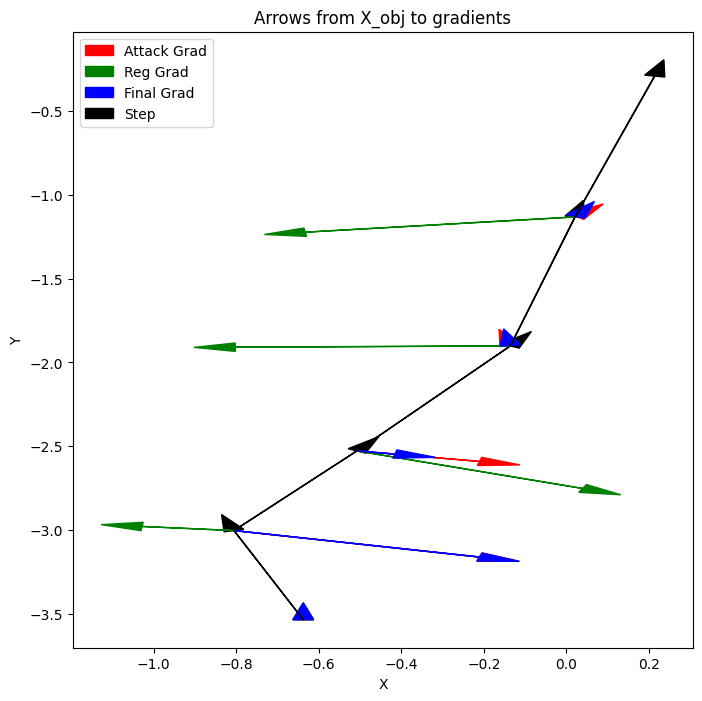

In [93]:
attack_params = dict()
attack_params['eps'] = 0.03
attack_params['alpha'] = 1
attack_params['n_steps'] = 10
attack_params['disc_models'] = disc_model_reg
attack_params['use_sigmoid'] = False
attack_params['delta'] = torch.tensor(0.0)
attack_params['attack_step'] = hypercone_fgsm_step_grads

loader = test_loader

prepare_draw_arrow_plot(
    attack_model, 
    criterion, 
    loader, 
    attack_params, 
    obj_id=3,
    n_steps_draw=5
)

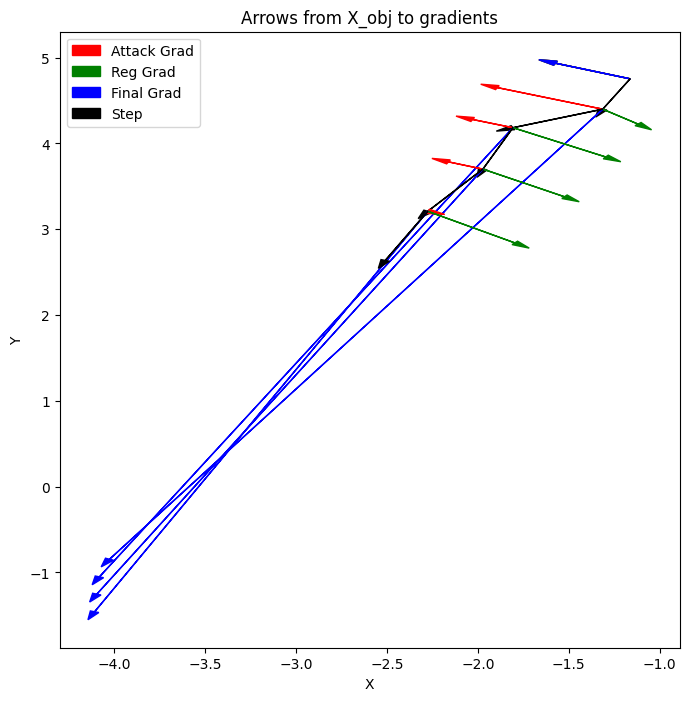

In [94]:
attack_params = dict()
attack_params['eps'] = 0.03
attack_params['alpha'] = 1
attack_params['n_steps'] = 10
attack_params['disc_models'] = disc_model_reg
attack_params['use_sigmoid'] = False
attack_params['delta'] = torch.tensor(0.0)
attack_params['attack_step'] = disc_fgsm_step_grads

loader = test_loader

prepare_draw_arrow_plot(
    attack_model, 
    criterion, 
    loader, 
    attack_params, 
    obj_id=3,
    n_steps_draw=5
)

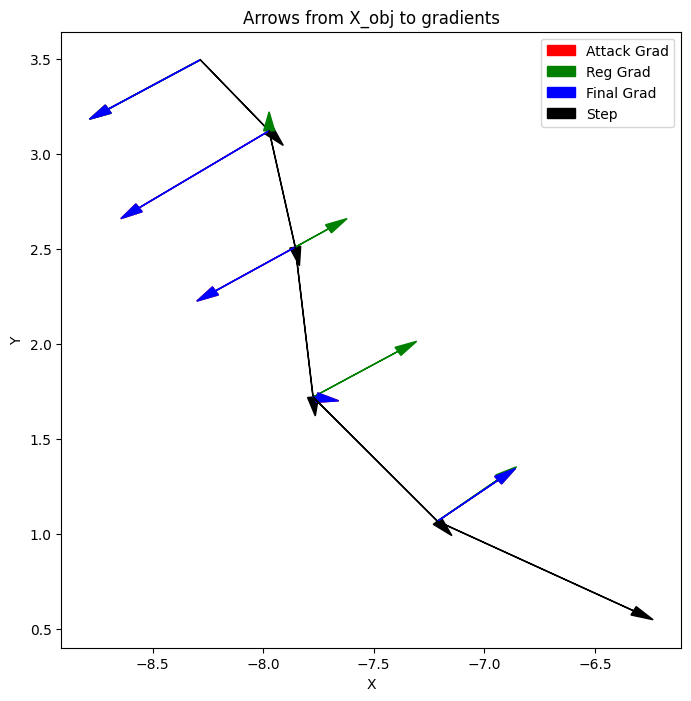

In [96]:
attack_params = dict()
attack_params['eps'] = 0.03
attack_params['alpha'] = 1
attack_params['n_steps'] = 10
attack_params['disc_models'] = disc_model_reg
attack_params['use_sigmoid'] = False
attack_params['delta'] = torch.tensor(0.0)
attack_params['attack_step'] = fgsm_step_grads

loader = test_loader

prepare_draw_arrow_plot(
    attack_model, 
    criterion, 
    loader, 
    attack_params, 
    obj_id=3,
    n_steps_draw=5
)

In [ ]:
obj_id = 3

X_obj = X_data_steps[:, :, obj_id, :]
attack_grad_obj = attack_loss_grad_steps[:, :, obj_id, :]
reg_grad_obj = reg_loss_grad_steps[:, :, obj_id, :]
final_grad_obj = final_grad_steps[:, :, obj_id, :]
eps_step_obj = eps_step_steps[:, :, obj_id, :]

# X_obj = X_obj[:-1].squeeze(-1)
# attack_grad_obj = X_obj + attack_grad_obj[1:].squeeze(-1)
# reg_grad_obj = X_obj + reg_grad_obj[1:].squeeze(-1)
# final_grad_obj = X_obj + final_grad_obj[1:].squeeze(-1)
# eps_step_obj = X_obj + eps_step_obj[1:].squeeze(-1)

X_obj = X_obj.squeeze(-1)
attack_grad_obj = X_obj + attack_grad_obj.squeeze(-1)
reg_grad_obj = X_obj + reg_grad_obj.squeeze(-1)
final_grad_obj = X_obj + final_grad_obj.squeeze(-1)
eps_step_obj = X_obj + eps_step_obj.squeeze(-1)

n_onj = X_obj.shape[0]
all_data = torch.cat((X_obj, attack_grad_obj, reg_grad_obj, final_grad_obj, eps_step_obj)).numpy()
all_data.shape

(55, 180)

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
all_data = tsne.fit_transform(all_data)

X_obj, attack_grad_obj, reg_grad_obj, final_grad_obj, eps_step_obj = all_data.reshape(5, n_onj, 2)

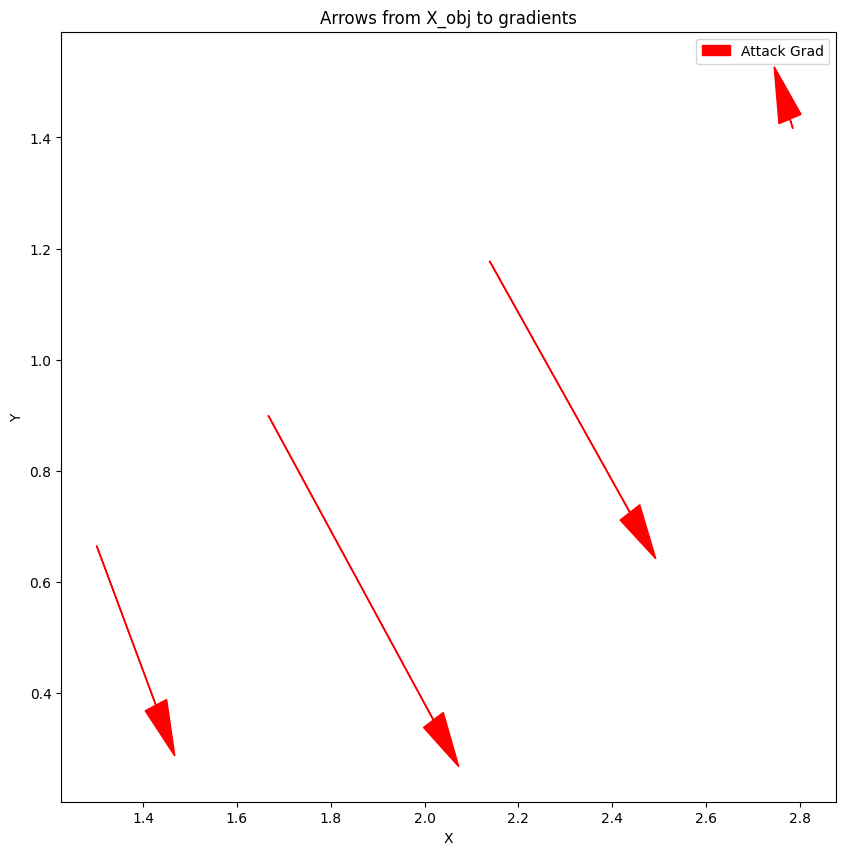

In [ ]:
# Create a plot
plt.figure(figsize=(10, 10))

n_steps = X_obj.shape[0]
n_steps = 5

# Loop through each line in the arrays
for i in range(n_steps - 1):
    # Extract the start and end points for the arrows
    start = X_obj[i]
    end_attack = attack_grad_obj[i]
    end_reg = reg_grad_obj[i]
    end_final = final_grad_obj[i]
    end_eps_steps = X_obj[i + 1] 

    # Draw arrows
    plt.arrow(start[0], start[1], end_attack[0] - start[0], end_attack[1] - start[1],
              head_width=0.05, head_length=0.1, fc='r', ec='r', label='Attack Grad' if i == 0 else "")
    plt.arrow(start[0], start[1], end_reg[0] - start[0], end_reg[1] - start[1],
              head_width=0.05, head_length=0.1, fc='g', ec='g', label='Reg Grad' if i == 0 else "")
    plt.arrow(start[0], start[1], end_final[0] - start[0], end_final[1] - start[1],
              head_width=0.05, head_length=0.1, fc='b', ec='b', label='Final Grad' if i == 0 else "")
    plt.arrow(start[0], start[1], end_eps_steps[0] - start[0], end_eps_steps[1] - start[1],
              head_width=0.05, head_length=0.1, fc='black', ec='black', label='Step' if i == 0 else "")

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Arrows from X_obj to gradients')

# Show the plot
plt.show()

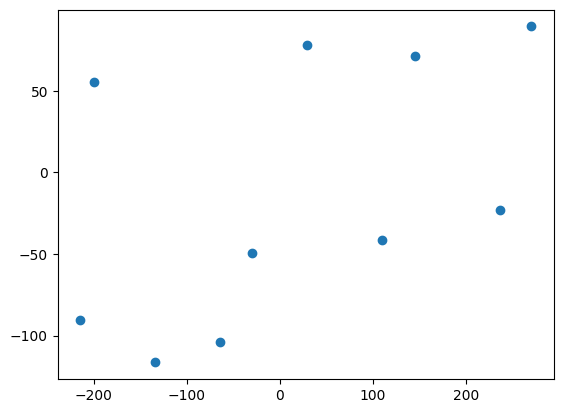

In [80]:
import matplotlib.pyplot as plt

plt.scatter(X_obj[:, 0], X_obj[:, 1])